### Guilherme Marques - 1921160

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel("all_1nm_data.xls", skiprows=range(0, 3))
visible_light_df = df[(df.nm > 379) & (df.nm < 781)]
visible_light_df.describe()

,nm,CIE A,CIE D65,VM(l),V'(l),x bar,y bar,z bar,x bar.1,y bar.1,z bar.1
count,401.000000,401.000000,401.000000,401.000000,4.010000e+02,401.000000,401.000000,401.000000,401.000000,401.000000,180.000000
mean,580.000000,117.968047,87.872599,0.268041,2.420731e-01,0.266472,0.266475,0.266449,0.290892,0.290927,0.648178
std,115.902977,73.707137,18.140484,0.347921,3.374294e-01,0.329757,0.349028,0.528957,0.353109,0.351927,0.725886
min,380.000000,9.795100,46.418200,0.000015,1.390000e-07,0.000042,0.000015,0.000000,0.000033,0.000013,0.000047
25%,480.000000,48.242300,73.074500,0.003458,7.150000e-05,0.007582,0.001704,0.000000,0.007116,0.002976,0.031871
50%,580.000000,114.436000,88.838900,0.060000,2.113000e-02,0.113275,0.060000,0.001650,0.135200,0.096275,0.264143
75%,680.000000,185.429000,104.405000,0.503000,4.650000e-01,0.359700,0.503000,0.168561,0.394750,0.561180,1.291265
max,780.000000,241.675000,117.812000,1.000000,1.000000e+00,1.062910,1.000000,1.782968,1.134300,1.000000,2.027300


In [3]:
visible_light_df.head(1)  # sanity check

,nm,CIE A,CIE D65,VM(l),V'(l),x bar,y bar,z bar,x bar.1,y bar.1,z bar.1
80,380,9.7951,49.9755,0.0002,0.000589,0.001368,0.000039,0.00645,0.00016,0.000017,0.000705


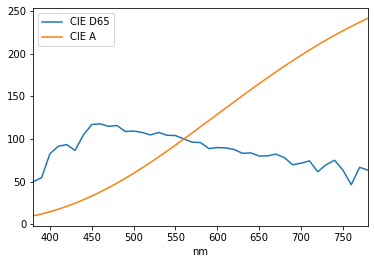

In [4]:
ax = plt.gca()
visible_light_df.plot(kind="line", x="nm", y="CIE D65", ax=ax)
visible_light_df.plot(kind="line", x="nm", y="CIE A", ax=ax)

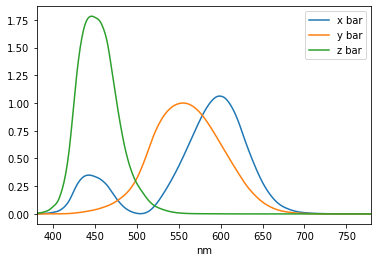

In [5]:
ax = plt.gca()
visible_light_df.plot(kind="line", x="nm", y="x bar", ax=ax)
visible_light_df.plot(kind="line", x="nm", y="y bar", ax=ax)
visible_light_df.plot(kind="line", x="nm", y="z bar", ax=ax)

In [19]:
xyz_to_srgb = np.array([
    [3.240710, -1.537260, -0.498571],
    [-0.969258, 1.875990, 0.041556],
    [0.055635, -0.203996, 1.057070]
])
xyz_to_applergb = np.array([
    [2.9515373, -1.2894116, -0.4738445],
    [-1.0851093, 1.9908566, 0.0372026],
    [0.0854934, -0.2694964, 1.0912975]
])

In [33]:
cieD65 = visible_light_df["CIE D65"].to_numpy(dtype=np.float32)
xyzbar = visible_light_df[['x bar', 'y bar', 'z bar']].to_numpy(
    dtype=np.float32)
print("xyzbar shape: {0} \ncieD65 shape: {1}".format(xyzbar.shape, cieD65.shape))

xyzbar shape: (401, 3) 
cieD65 shape: (401,)


In [8]:
spectra_df = pd.read_excel(
    "ColorChecker_RGB_and_spectra.xls",
    sheet_name="spectral_data", skiprows=range(0, 1), nrows=24)
spectra_df.tail(1)

,No.,Color name,380,390,400,410,420,430,440,450,...,640,650,660,670,680,690,700,710,720,730
23,24,black 2 (1.5 D),0.031118,0.031818,0.032134,0.032363,0.032572,0.032659,0.032684,0.032463,...,0.031603,0.031615,0.031699,0.03184,0.031998,0.031996,0.031992,0.032072,0.032106,0.032211


In [9]:
spectral_data = spectra_df.loc[:, spectra_df.columns[2:]].to_numpy(
    dtype=np.float32)
spectral_data.shape

(24, 36)

In [34]:
def spectral_to_rgb(spectral_data, illuminant, xyz_to_rgb, gamma=True):
    wavelengths_index = [i for i in range(0, 360, 10)]
    LB = (illuminant[wavelengths_index] * spectral_data).T
    XYZ = xyzbar[wavelengths_index].T.dot(LB)
    k = illuminant[wavelengths_index].dot(xyzbar[wavelengths_index, 1])
    XYZ = XYZ / k
    rgb = xyz_to_rgb.dot(XYZ)
    if gamma:
        rgb[rgb < -0.0031308] = -(1.055*(-rgb[rgb < -0.0031308])**(1/2.4)-0.055)
        rgb[(rgb >= -0.0031308) & (rgb < 0)] = rgb[(rgb >= -0.0031308) & (rgb < 0)]*12.92
        rgb[rgb > 0.0031308] = 1.055*rgb[rgb > 0.0031308]**(1/2.4) - 0.055
        rgb[(rgb <= 0.0031308) & (rgb > 0)] = rgb[(rgb <= 0.0031308) & (rgb > 0)]*12.92
    y, x = np.array([(i, j) for i in range(4) for j in range(6)]).T    
    y, x = np.array([(i, j) for i in range(4) for j in range(6)]).T
    plt.figure(figsize=(11.69,8.27))
    plt.scatter(x, y, c=np.clip(rgb, 0, 1).T, s=3000)

## With gamma correction

sRGB conversion matrix


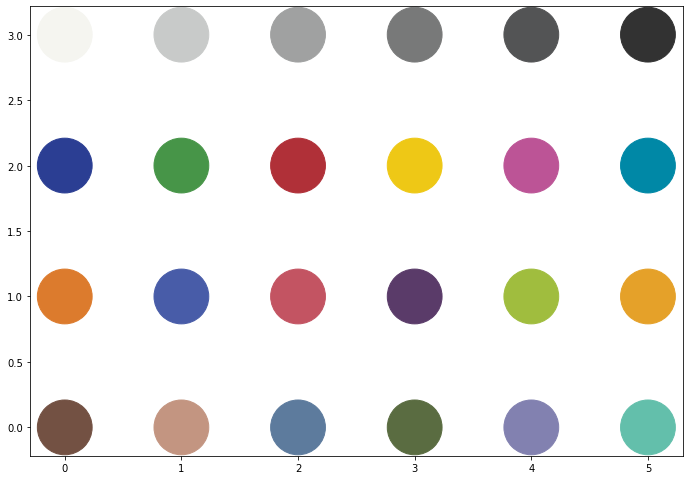

In [35]:
print("sRGB conversion matrix")
spectral_to_rgb(spectral_data, cieD65, xyz_to_srgb)

AppleRGB conversion matrix


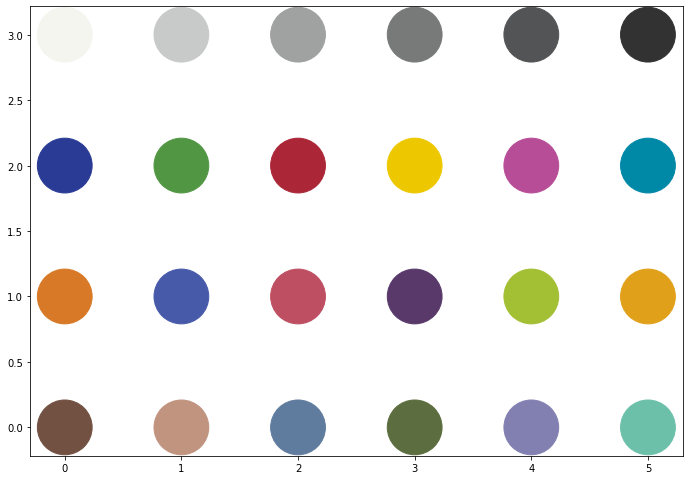

In [20]:
print("AppleRGB conversion matrix")
spectral_to_rgb(spectral_data, cieD65, xyz_to_applergb)

## Without gamma correction

sRGB conversion matrix


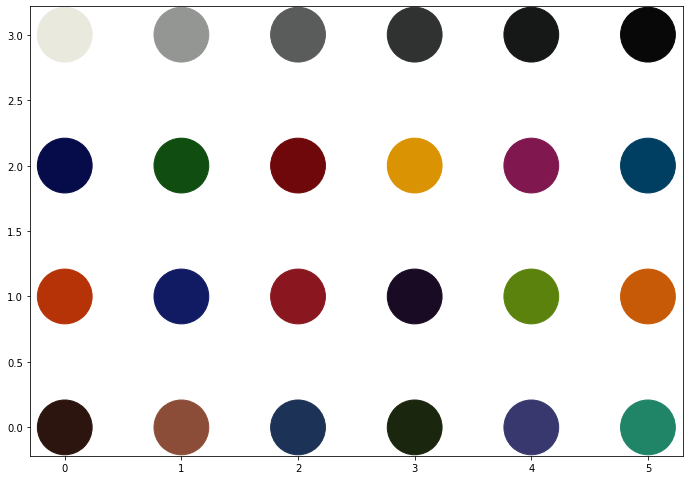

In [22]:
print("sRGB conversion matrix")
spectral_to_rgb(spectral_data, cieD65, xyz_to_srgb, gamma=False)

AppleRGB conversion matrix


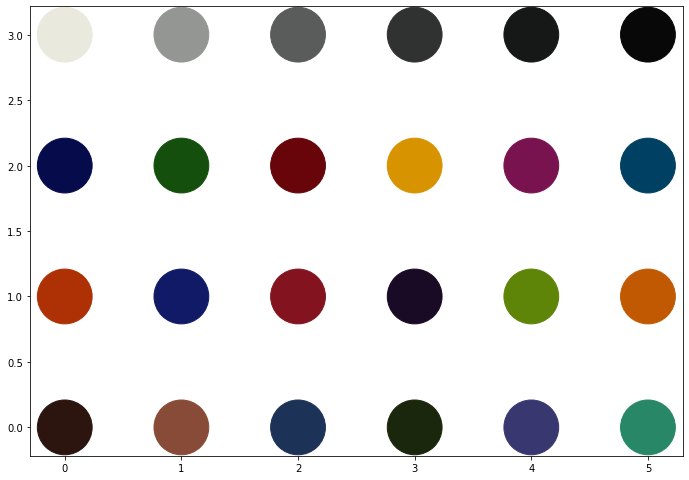

In [21]:
print("AppleRGB conversion matrix")
spectral_to_rgb(spectral_data, cieD65, xyz_to_applergb, gamma=False)